### Build the dataset

In [29]:
from transformers import AutoTokenizer
from trl.core import LengthSampler
from datasets import load_dataset

def build_dataset(model_name='gpt2', dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

dataset = build_dataset()

Found cached dataset imdb (/Users/naowak/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Loading cached processed dataset at /Users/naowak/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c800109586d11f73.arrow
Loading cached processed dataset at /Users/naowak/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-53146ae257fbea76.arrow


### Load the reward function

In [33]:
from transformers import pipeline

sentiment_pipe = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device='mps:0')

### Loop

In [67]:
# imports
import torch
from tqdm import tqdm
from transformers import AutoTokenizer
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from trl.core import respond_to_batch

# get models
model = AutoModelForCausalLMWithValueHead.from_pretrained('gpt2')
model_ref = create_reference_model(model)
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

# initialize trainer
ppo_config = PPOConfig(
    batch_size=128,
    learning_rate=1.41e-5,
)

def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

# create a ppo trainer
ppo_trainer = PPOTrainer(ppo_config, model, model_ref, tokenizer, dataset=dataset, data_collator=collator)

# stats
stats = []

for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):

    # Respond to batch
    query_tensors = [t.unsqueeze(0) for t in batch["input_ids"]]
    response_tensors = []
    for query_tensor in query_tensors:
        response_tensor = respond_to_batch(model, query_tensor)
        response_tensors.append(response_tensor)
    batch["response"] = tokenizer.batch_decode([r[0] for r in response_tensors])

    # Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, return_all_scores=True, function_to_apply=None, batch_size=16)
    rewards = [torch.tensor(output[1]["score"]).to('mps:0') for output in pipe_outputs]

    # Run PPO step
    q = [t[0] for t in query_tensors]
    r = [t[0] for t in response_tensors]
    ppo_trainer.step(q, r, rewards) ### probleme here, needs to resolve
    ppo_trainer.log_stats(stats, batch, rewards)


0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
0it [01:47, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 2 but got size 20 for tensor number 1 in the list.

### See plots

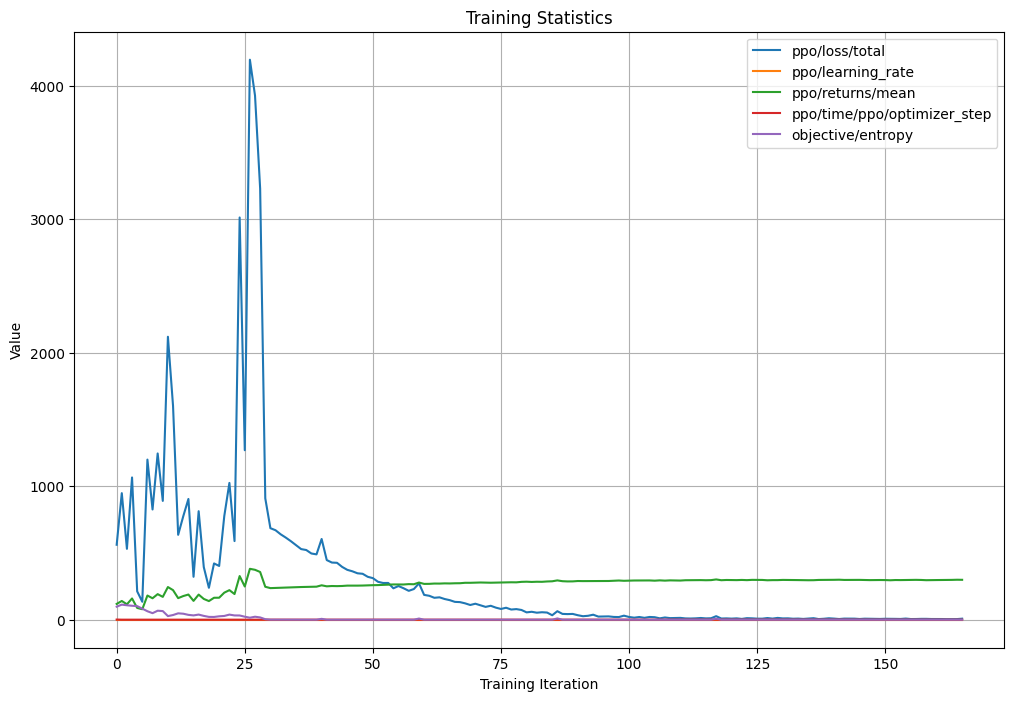

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming stats is the list containing your training statistics
# Example: stats = [dict1, dict2, dict3, ...]

keys_of_interest = [
    'ppo/loss/total',
    'ppo/learning_rate',
    'ppo/returns/mean',
    #'ppo/val/error',
    'ppo/time/ppo/optimizer_step',
    'objective/entropy'
    # add more keys that you are interested in
]

# Extract the data for the keys of interest
data = {}
for key in keys_of_interest:
    data[key] = []

for entry in stats:
    for key in keys_of_interest:
        if key in entry:
            data[key].append(entry[key])

# Plot the data
plt.figure(figsize=(12, 8))

for key, values in data.items():
    plt.plot(values, label=key)

plt.xlabel('Training Iteration')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.title('Training Statistics')
plt.show()